# Question answering system

Question answering is a computer science discipline within the fields of information retrieval and natural language processing, which is concerned with building systems that automatically answer questions posed by humans in a natural language.

![qa.png](qa.png)

The objective here is to build a Question answering system using the seq2seq approach.

### SQuAD Dataset

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.

We can download the dataset from [here](https://rajpurkar.github.io/SQuAD-explorer/)

In [3]:
# Importing packages
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation,RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import History
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Getting Data


In [4]:
!wget "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
!wget "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"

--2021-07-19 00:56:36--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   123MB/s    in 0.3s    

2021-07-19 00:56:38 (123 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2021-07-19 00:56:38--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.110.153, 185.199.108.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [5]:
% cd content

[Errno 2] No such file or directory: 'content'
/content


In [6]:
with open("train-v2.0.json",mode="rt",encoding="utf-8") as file:
    qa_data = json.load(file)

In [7]:
#qa_data["data"][0]['paragraphs'][0]["qas"][0]["question"]
#qa_data["data"][0]['paragraphs'][0]["qas"][0]["answers"]

## 2. Pre-processing

In [8]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
# check for valid characters
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [9]:
# extract paragraphs,question and answers from SQuAD_data
def get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length):
    data = list()
    for instance in qa_data['data']:
        for paragraph in instance['paragraphs']:
            context = paragraph['context']
            context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
            if len(context_wid_list) > max_context_seq_length:
                continue
            qas = paragraph['qas']
            for qas_instance in qas:
                question = qas_instance['question']
                question_wid_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
                if len(question_wid_list) > max_question_seq_length:
                    continue
                answers = qas_instance['answers']
                for answer in answers:
                    ans = answer['text']
                    answer_wid_list = [w.lower() for w in nltk.word_tokenize(ans) if in_white_list(w)]
                    if len(answer_wid_list) > max_target_seq_length:
                        continue
                    if len(data) < max_data_count:
                        data.append((context, question, ans))

            if len(data) >= max_data_count:
                break

            break
    return data

In [10]:
max_data_count = 10000
max_context_seq_length = 300
max_question_seq_length = 60
max_target_seq_length = 50
data = get_SQuAD_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length)
print("Total Q&A data size",len(data))

Total Q&A data size 2350


## 3. Feature Extraction

### Create dictionnary
The first step is to create the dictionnary, it means, the list of all words contained in texts. For each word, we will assign an index to it.

In [11]:
max_input_vocab_size = 5000
max_target_vocab_size = 5000

input_data_samples = []
output_data_samples = []

input_paragraph_max_seq_length = 0
input_question_max_seq_length = 0
target_max_seq_length = 0

input_paragraph_counter = Counter()
input_question_counter = Counter()
target_counter = Counter()
# iterate over each paragraph, question and answer
for sample in data:
    paragraph, question, answer = sample
    paragraph_word_list = [w.lower() for w in nltk.word_tokenize(paragraph) if in_white_list(w)]
    question_word_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
    answer_word_list = [w.lower() for w in nltk.word_tokenize(answer) if in_white_list(w)]

    output_data = ['START'] + answer_word_list + ['END']

    input_data_samples.append([paragraph_word_list, question_word_list])
    output_data_samples.append(output_data)

    for w in paragraph_word_list:
        input_paragraph_counter[w] += 1
    for w in question_word_list:
        input_question_counter[w] += 1
    for w in output_data:
        target_counter[w] += 1

    input_paragraph_max_seq_length = max(input_paragraph_max_seq_length, len(paragraph_word_list))
    input_question_max_seq_length = max(input_question_max_seq_length, len(question_word_list))
    target_max_seq_length = max(target_max_seq_length, len(output_data))

In [12]:
input_paragraph_word2idx = dict()
input_question_word2idx = dict()
target_word2idx = dict()

# Mapping from word to index
for idx, word in enumerate(input_paragraph_counter.most_common(max_input_vocab_size)):
    input_paragraph_word2idx[word[0]] = idx + 2
for idx, word in enumerate(input_question_counter.most_common(max_input_vocab_size)):
    input_question_word2idx[word[0]] = idx + 2
for idx, word in enumerate(target_counter.most_common(max_target_vocab_size)):
    target_word2idx[word[0]] = idx + 1

target_word2idx['UNK'] = 0
input_paragraph_word2idx['PAD'] = 0
input_paragraph_word2idx['UNK'] = 1
input_question_word2idx['PAD'] = 0
input_paragraph_word2idx['UNK'] = 1

# Mapping from index to word
input_paragraph_idx2word = dict([(idx, word) for word, idx in input_paragraph_word2idx.items()])
input_question_idx2word = dict([(idx, word) for word, idx in input_question_word2idx.items()])
target_idx2word = dict([(idx, word) for word, idx in target_word2idx.items()])

num_input_paragraph_tokens = len(input_paragraph_idx2word)
num_input_question_tokens = len(input_question_idx2word)
num_target_tokens = len(target_idx2word)

### Create sequences

Assign index to each word in texts 

In [13]:
input_encoded_data_samples = []
target_encoded_data_samples = []
# iterate over each text sample from paragraphs, questions and answers
for input_data, output_data in zip(input_data_samples, output_data_samples):
    input_paragraph_encoded_data = []
    input_question_encoded_data = []
    target_encoded_data = []
    input_paragraph_data, input_question_data = input_data
    for word in input_paragraph_data:
        if word in input_paragraph_word2idx:
            input_paragraph_encoded_data.append(input_paragraph_word2idx[word])
        else:
            input_paragraph_encoded_data.append(1)
    for word in input_question_data:
        if word in input_question_word2idx:
            input_question_encoded_data.append(input_question_word2idx[word])
        else:
            input_question_encoded_data.append(1)
    for word in output_data:
        if word in target_word2idx:
            target_encoded_data.append(target_word2idx[word])
        else:
            target_encoded_data.append(0)
    input_encoded_data_samples.append([input_paragraph_encoded_data, input_question_encoded_data])
    target_encoded_data_samples.append(target_encoded_data)

In [14]:
batch_size = 64
epochs = 200
test_size = 0.2
random_state = 42

In [15]:
# get train and test samples
x_train, x_test, y_train, y_test = train_test_split(input_encoded_data_samples, target_encoded_data_samples, test_size=test_size,random_state=random_state)

In [16]:
# train and test generator
def generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, input_data, output_data, batch_size):
    num_batches = len(input_data) // batch_size
    while True:
        for batchIdx in range(0, num_batches):
            start = batchIdx * batch_size
            end = (batchIdx + 1) * batch_size
            encoder_input_paragraph_data_batch = []
            encoder_input_question_data_batch = []
            for input_paragraph_data, input_question_data in input_data[start:end]:
                encoder_input_paragraph_data_batch.append(input_paragraph_data)
                encoder_input_question_data_batch.append(input_question_data)
            encoder_input_paragraph_data_batch = pad_sequences(encoder_input_paragraph_data_batch,
                                                               input_paragraph_max_seq_length)
            encoder_input_question_data_batch = pad_sequences(encoder_input_question_data_batch,
                                                              input_question_max_seq_length)
            decoder_target_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            decoder_input_data_batch = np.zeros(shape=(batch_size, target_max_seq_length, num_target_tokens))
            for lineIdx, target_wid_list in enumerate(output_data[start:end]):
                for idx, wid in enumerate(target_wid_list):
                    if wid == 0:  # UNKNOWN
                        continue
                    decoder_input_data_batch[lineIdx, idx, wid] = 1
                    if idx > 0:
                        decoder_target_data_batch[lineIdx, idx - 1, wid] = 1
            yield [encoder_input_paragraph_data_batch, encoder_input_question_data_batch,
                   decoder_input_data_batch], decoder_target_data_batch

In [17]:
# get train and test generators
train_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_train, y_train, batch_size)
test_gen = generate_batch(input_paragraph_max_seq_length,input_question_max_seq_length,target_max_seq_length,num_target_tokens, x_test, y_test, batch_size)

In [18]:
# get train and test batch size
train_num_batches = len(x_train) // batch_size
test_num_batches = len(x_test) // batch_size

## 4. Build the model

![encode_decode.jpeg](encode_decode.jpeg)

In [19]:
def create_model(num_encoder_paragraph_tokens,max_encoder_paragraph_seq_length,
                 num_encoder_question_tokens,max_encoder_question_seq_length,num_decoder_tokens):

    hidden_units = 256
    embed_hidden_units = 100

    context_inputs = Input(shape=(None,), name='context_inputs')
    encoded_context = Embedding(input_dim=num_encoder_paragraph_tokens, output_dim=embed_hidden_units,
                                    input_length=max_encoder_paragraph_seq_length,
                                    name='context_embedding')(context_inputs)
    encoded_context = Dropout(0.3)(encoded_context)

    question_inputs = Input(shape=(None,), name='question_inputs')
    encoded_question = Embedding(input_dim=num_encoder_question_tokens+1, output_dim=embed_hidden_units,
                                     input_length=max_encoder_question_seq_length,
                                     name='question_embedding')(question_inputs)
    encoded_question = Dropout(0.3)(encoded_question)
    encoded_question = LSTM(units=embed_hidden_units, name='question_lstm')(encoded_question)
    encoded_question = RepeatVector(max_encoder_paragraph_seq_length)(encoded_question)

    merged = add([encoded_context, encoded_question])

    encoder_lstm = LSTM(units=hidden_units, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(merged)
    encoder_states = [encoder_state_h, encoder_state_c]

    decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')
    decoder_lstm = LSTM(units=hidden_units, return_state=True, return_sequences=True, name='decoder_lstm')
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_inputs,
                                                                         initial_state=encoder_states)
    decoder_dense = Dense(units=num_decoder_tokens, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([context_inputs, question_inputs, decoder_inputs], decoder_outputs)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    encoder_model = Model([context_inputs, question_inputs], encoder_states)

    decoder_state_inputs = [Input(shape=(hidden_units,)), Input(shape=(hidden_units,))]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs] + decoder_states)

    return model, encoder_model, decoder_model

In [20]:
model, encoder_model, decoder_model = create_model(num_input_paragraph_tokens,input_paragraph_max_seq_length,
                 num_input_question_tokens,input_question_max_seq_length,num_target_tokens)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
question_inputs (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
question_embedding (Embedding)  (None, None, 100)    381500      question_inputs[0][0]            
__________________________________________________________________________________________________
context_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, None, 100)    0           question_embedding[0][0]         
______________________________________________________________________________________________

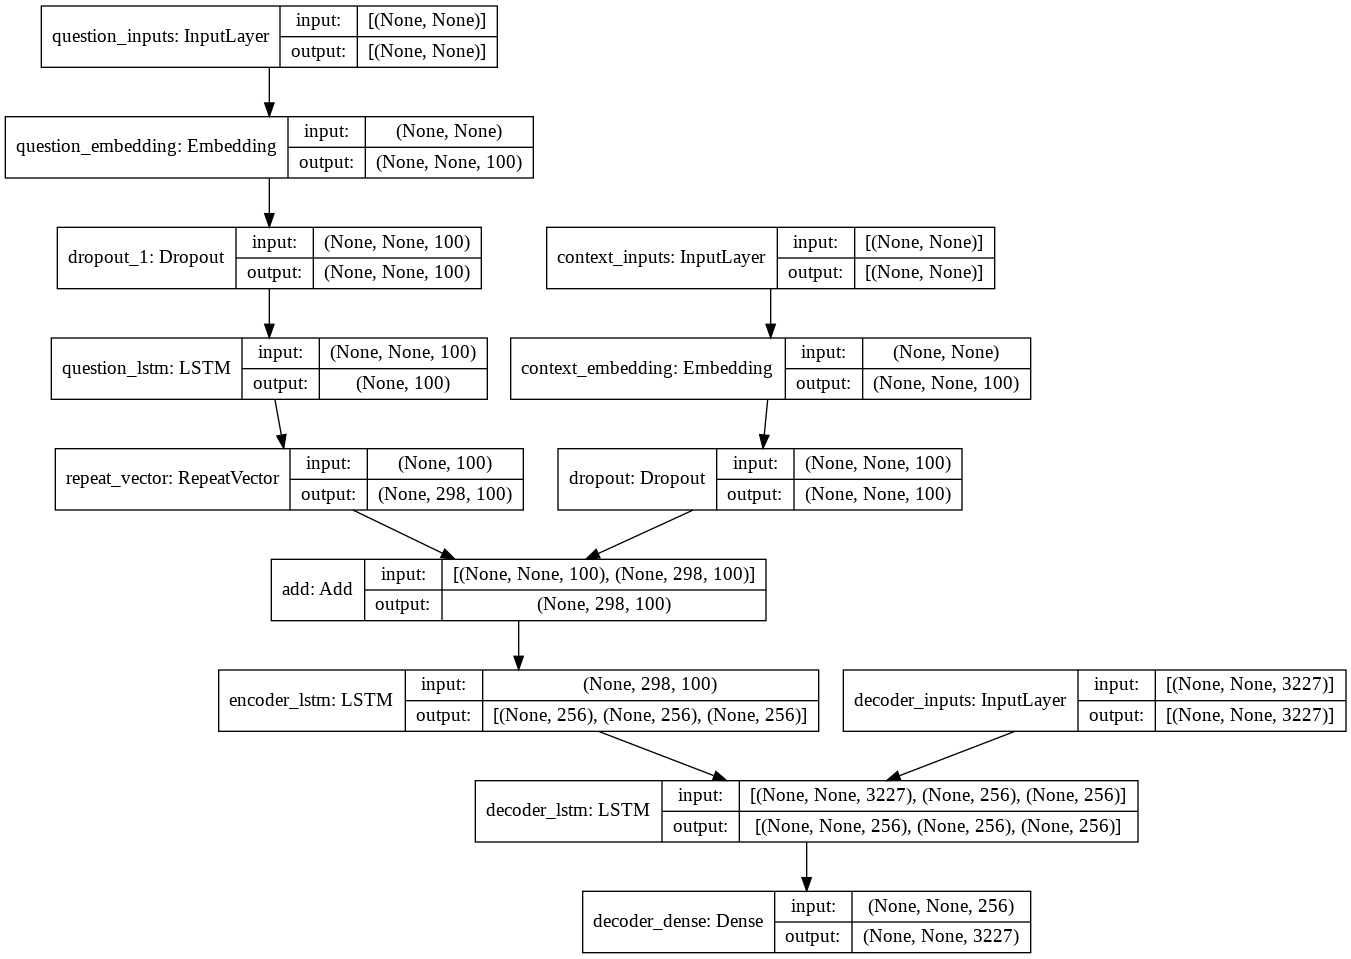

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [22]:
# Defining a helper function to save the model after each epoch 
# in which the loss decreases 
filepath = 'model_QandA.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Defining a helper function to reduce the learning rate each time 
# the learning plateaus 
reduce_alpha = ReduceLROnPlateau(monitor ='val_loss', factor = 0.2, patience = 1, min_lr = 0.001)
# stop traning if there increase in loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
callbacks = [checkpoint, reduce_alpha] 

## 5. Train the model

In [23]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=train_num_batches,
                                           epochs=epochs,
                                           verbose=1, validation_data=test_gen, validation_steps=test_num_batches,
                                           callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
29/29 [==============================] - 14s 150ms/step - loss: 0.7650 - accuracy: 0.0268 - val_loss: 0.7541 - val_accuracy: 0.0278

Epoch 00001: val_loss improved from inf to 0.75413, saving model to model_QandA.h5
Epoch 2/200
 1/29 [>.............................] - ETA: 2s - loss: 0.8669 - accuracy: 0.0278

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


29/29 [==============================] - 3s 102ms/step - loss: 0.7248 - accuracy: 0.0278 - val_loss: 0.7587 - val_accuracy: 0.0278

Epoch 00002: val_loss did not improve from 0.75413
Epoch 3/200
29/29 [==============================] - 3s 102ms/step - loss: 0.7241 - accuracy: 0.0278 - val_loss: 0.7631 - val_accuracy: 0.0278

Epoch 00003: val_loss did not improve from 0.75413
Epoch 4/200
29/29 [==============================] - 3s 101ms/step - loss: 0.7241 - accuracy: 0.0278 - val_loss: 0.7673 - val_accuracy: 0.0278

Epoch 00004: val_loss did not improve from 0.75413
Epoch 5/200
29/29 [==============================] - 3s 106ms/step - loss: 0.7239 - accuracy: 0.0278 - val_loss: 0.7716 - val_accuracy: 0.0278

Epoch 00005: val_loss did not improve from 0.75413
Epoch 6/200
29/29 [==============================] - 3s 105ms/step - loss: 0.7236 - accuracy: 0.0278 - val_loss: 0.7762 - val_accuracy: 0.0289

Epoch 00006: val_loss did not improve from 0.75413
Epoch 7/200
29/29 [==================

## 6. Test the model

In [24]:
def reply(paragraph, question):
    input_paragraph_seq = []
    input_question_seq = []
    input_paragraph_wid_list = []
    input_question_wid_list = []
    input_paragraph_text = paragraph.lower()
    input_question_text = question.lower()
    for word in nltk.word_tokenize(input_paragraph_text):
        if not in_white_list(word):
            continue
        idx = 1  # default [UNK]
        if word in input_paragraph_word2idx:
            idx = input_paragraph_word2idx[word]
        input_paragraph_wid_list.append(idx)
    for word in nltk.word_tokenize(input_question_text):
        if not in_white_list(word):
            continue
            idx = 1  # default [UNK]
        if word in input_question_word2idx:
            idx = input_question_word2idx[word]
        input_question_wid_list.append(idx)
    input_paragraph_seq.append(input_paragraph_wid_list)
    input_question_seq.append(input_question_wid_list)

    input_paragraph_seq = pad_sequences(input_paragraph_seq, input_paragraph_max_seq_length)
    input_question_seq = pad_sequences(input_question_seq, input_question_max_seq_length)
    states_value = encoder_model.predict([input_paragraph_seq, input_question_seq])

    target_seq = np.zeros((1, 1, num_target_tokens))
    target_seq[0, 0, target_word2idx['START']] = 1
    target_text = ''
    target_text_len = 0
    terminated = False
    while not terminated:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sample_token_idx = np.argmax(output_tokens[0, -1, :])
        sample_word = target_idx2word[sample_token_idx]
        target_text_len += 1

        if sample_word != 'START' and sample_word != 'END':
            target_text += ' ' + sample_word

        if sample_word == 'END' or target_text_len >= target_max_seq_length:
            terminated = True

        target_seq = np.zeros((1, 1, num_target_tokens))
        target_seq[0, 0, sample_token_idx] = 1

        states_value = [h, c]
    return target_text.strip()

In [25]:
for i in range(20):
    index = i * 10
    paragraph, question, actual_answer = data[index]
    predicted_answer = reply(paragraph, question)
    print('context: ', paragraph)
    print('question: ', question)
    print({'guessed_answer': predicted_answer, 'actual_answer': actual_answer})
    print("\n")

context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
question:  When did Beyonce start becoming popular?
{'guessed_answer': '', 'actual_answer': 'in the late 1990s'}


context:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Hous